# Run LFMC Scenario C
This notebook reproduces Scenario 'C' presented in "Live fuel moisture content estimation from MODIS" (Zhu et al., 2010). In this scenario, the samples are randomly split into training and test sets.

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm

from lfmc_model import LfmcTempCnn
from model_utils import reshape_data, normalise, plot_results
from modelling_functions import run_test
from model_parameters import ModelParams

## Directories and Input files
Change these settings as required
- `input_dir`: Directory containing the data extracted from GEE and Globe-LFMC, the outputs from running the `Extract DEM Data.ipynb` and `Extract MODIS Data.ipynb` notebooks.
- `output_dir`: A sub-directory called `model_params['modelName']` (`Scenario_A`) will be created in this directory, where all outputs generated by this notebook will be written. 
- `temp_dir`: A temporary directory where model checkpoints are created. This directory should exist and be empty.
- `modis_csv`: The file containing extracted MODIS data for each sample, created by `Extract MODIS Data.ipynb`
- `aux_csv`: The file containing extracted DEM and other auxiliary data for each sample, created by `Extract DEM Data.ipynb`. This includes the labels and pre-processed site location and sampling date data from Globe-LFMC

In [2]:
input_dir = r'G:\My Drive\LFMC from MODIS\TrainingData'
output_dir = r'G:\My Drive\LFMC from MODIS\Models'
temp_dir = r'C:\Temp\LFMC'
modis_csv = os.path.join(input_dir, 'modis.csv')
aux_csv = os.path.join(input_dir, 'sample.csv')

## Set up model parameters
Set up and customise the model parameters. Leave all parameters as set here to run Scenario C. To find out more about any parameter, run `model_params.help('<parameter>')` after running this cell to create the ModelParams object.

In [3]:
# Customize model parameters
model_params = ModelParams(conv_layers=3, fc_layers=2)

model_params['modelName'] = 'Scenario_C'
model_params['description'] = 'Estimate LFMC for Globel-LFMC samples using randomly generated training and test sets.'
model_params['modisFilename'] = modis_csv
model_params['auxFilename'] = aux_csv
model_params['splitMethod'] = 'random'

model_params['tempDir'] = temp_dir
model_params['modelDir'] = os.path.join(output_dir, model_params['modelName'])
if not os.path.exists(model_params['modelDir']):
    os.makedirs(model_params['modelDir'])

model_params['conv'][0]['poolSize'] = 2
model_params['conv'][1]['poolSize'] = 3
model_params['conv'][2]['poolSize'] = 4

model_params

{'modelName': 'Scenario_C',
 'description': 'Estimate LFMC for Globel-LFMC samples using randomly generated training and test sets.',
 'modelDir': 'G:\\My Drive\\LFMC from MODIS\\Models\\Scenario_C',
 'tempDir': 'C:\\Temp\\LFMC',
 'randomSeed': 1234,
 'modelRuns': 1,
 'resplit': False,
 'seedList': [],
 'modisFilename': 'G:\\My Drive\\LFMC from MODIS\\TrainingData\\modis.csv',
 'modisChannels': 7,
 'modisNormalise': {'method': 'minMax', 'percentiles': 2},
 'modisDays': 365,
 'auxFilename': 'G:\\My Drive\\LFMC from MODIS\\TrainingData\\sample.csv',
 'auxColumns': 9,
 'auxAugment': False,
 'targetColumn': 'LFMC value',
 'splitMethod': 'random',
 'splitSizes': (0.33, 0.086),
 'siteColumn': 'Site',
 'splitStratify': 'Land Cover',
 'splitYear': 2013,
 'yearColumn': 'Sampling year',
 'splitFolds': 0,
 'batchNormalise': True,
 'dropoutRate': 0.5,
 'regulariser': 'keras.regularizers.l2(1.e-6)',
 'validationSet': False,
 'earlyStopping': False,
 'epochs': 100,
 'batchSize': 32,
 'shuffle': True

## Prepare the data

In [4]:
modis_df = pd.read_csv(modis_csv)
modis_start = model_params['modisDays'] * model_params['modisChannels']
x_modis = reshape_data(np.array(modis_df.iloc[:, -modis_start:]), model_params['modisChannels'])
x_modis = normalise(x_modis, **model_params['modisNormalise'])
print(f'Modis shape: {x_modis.shape}')

aux_df = pd.read_csv(aux_csv, index_col=0)
y = aux_df[model_params['targetColumn']]
aux_start = len(aux_df.columns) - model_params['auxColumns']
x_aux = np.array(aux_df.iloc[:, aux_start:])
if model_params['auxAugment']:
    x_aux = np.concatenate([x_aux, x_modis[:, -1, :]], axis=1)
print(f'Auxiliary shape: {x_aux.shape}')

Modis shape: (65663, 365, 7)
Auxiliary shape: (65663, 9)


## Build and run the model
Builds and trains the LFMC model. After training the model, several derived models are created and evaluated. The full list of models is:
- `base` - The fully trained model
- `best` - A model using the checkpoint with the best training loss
- `merge10` - A model created by merging the last 10 checkpoints. The checkpoints are merged by averaging the corresponding weights from each model.
- `ensemble10` - An ensembled model of the last 10 checkpoints. This model averages the predictions made by each model in the ensemble to make the final prediction.
- `merge_best10` - Similar to the merge10 model, but uses the 10 checkpoints with the lowest training/validation losses.

All models, predictions, evaluation statistics, and plots of test results are saved to `model_dir`. Predictions and evaluation statistics are also returned as attributes of the `model` object.

In [5]:
with open(os.path.join(model_params['modelDir'], 'model_params.json'), 'w') as f:
    model_params.save(f)
model = run_test(model_params, aux_df, {'modis': x_modis, 'aux': x_aux}, y)

Training results: minLoss: 619.378173828125, runTime: 924.78


## Display the results
Display a summary of the statistics for each model
- Bias: The difference between the mean prediction and the mean label
- RMSE: The root mean squared error of the predictions
- ubRMSE (Unbiased RMSE): The RMSE obtained if each prediction is adjusted by the Bias
- R: The correlation coefficient
- R2 (R-squared): The percent of variance explained
- runTime: The time (in seconds) to predict all test samples

In [6]:
model.all_stats

,Bias,R,R2,RMSE,ubRMSE,runTime
base,-6.53,0.79,0.63,23.70,22.78,1.12
best,-4.47,0.78,0.60,23.97,23.55,0.84
merge_best10,-4.37,0.80,0.64,22.82,22.40,0.87
merge10,-4.42,0.80,0.64,22.84,22.41,0.87
ensemble10,-4.55,0.80,0.64,22.96,22.51,8.35


## Plot the Results
Create a scatter plot using the `merge10` results that compares the estimated LFMC to the measured LFMC of the test samples.

To plot any of the other models, change the value of `plot_model` to the required model. 

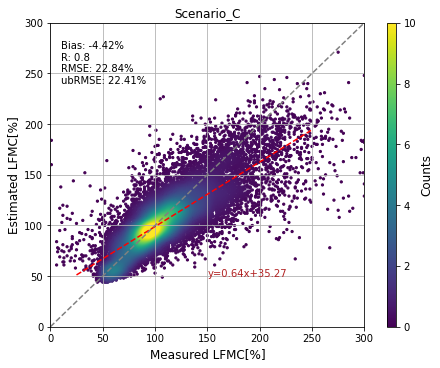

In [7]:
plot_model = 'merge10'
vmax = 10
fig = plt.figure(constrained_layout=True, figsize=(6, 5))
gspec = fig.add_gridspec(ncols=1, nrows=1)
plot = fig.add_subplot(gspec[0, 0])
plot_results(model_params['modelName'], model.all_results.y, model.all_results[plot_model], model.all_stats.loc[plot_model], ax=plot, vmax=vmax)
cbar = fig.colorbar(cm.ScalarMappable(norm = Normalize(vmin=0, vmax=vmax)), ax=fig.axes[0], aspect=40)
_ = cbar.ax.set_ylabel('Counts', fontsize=12)